In [1]:
import logging
from math import floor


import matplotlib.pyplot as plt
import datetime

try:
    from pathlib import Path
except ImportError:
    from pathlib2 import Path

import pandas as pd
import os
import numpy as np

logger = logging.getLogger(__name__)

%matplotlib qt

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "browser"

In [2]:

IMAGE_INPUT_WIDTH=160
IMAGE_INPUT_HEIGHT=120
# This discards number of pixels from the top after scaling
TOP_MARGIN_IN_PIXELS=8


col_img = 'image'
col_steering = 'msg.steering'
col_throttle = 'msg.throttle'
col_image_ts = 'image_timestamp'
col_steernig_ts = 'steering_timestamp'
col_steering_scaled = 'steering_scaled'
col_throttle_scaled = 'throttle_scaled'
col_validation = 'validation'

base_dir = Path("./data/")
def read_csv(path):
    df = pd.read_csv(path)
    for col in [col_img, col_steering, col_throttle, col_image_ts, col_steernig_ts]:
        assert col in df.columns, f'missing {col} in {path}'
    return df

# Read files and concatenate them

In [3]:
def load_and_merge_csvs(paths_csv):
    print('Loading {} csvs:\n{}'.format(len(paths_csv), '\n'.join(str(p) for p in paths_csv)))
    csvs = [read_csv(str(path)) for path in paths_csv]
    df = pd.concat(csvs, axis=0, ignore_index=True)
    print(f'loaded {df.shape}')
    return df

db_names =  [
        "sergem_robocar_20191009_v2",
        "sergem_robocar_20191106",
        "sergem_robocar_20191126_entrance",
        "sergem_robocar_20191127",
    ]
dfs = {
    db_name: load_and_merge_csvs(sorted(base_dir.glob(f"{db_name}/*.csv")))
    for db_name in db_names
}
# df1 = load_and_merge_csvs(sorted(base_dir.glob("sergem_robocar_20191003_v2/*.csv")))
# df2 = load_and_merge_csvs(sorted(base_dir.glob("*201911*/*.csv")))

Loading 3 csvs:
data/sergem_robocar_20191009_v2/robocar_recording_20191008_2016-02-11-16-43-19_0_f.csv
data/sergem_robocar_20191009_v2/robocar_recording_20191008_2016-02-11-16-46-19_1_f.csv
data/sergem_robocar_20191009_v2/robocar_recording_20191008_2016-02-11-16-49-19_2_f.csv
loaded (3968, 5)
Loading 23 csvs:
data/sergem_robocar_20191106/robocar_recording__2016-02-11-17-16-01_f.csv
data/sergem_robocar_20191106/robocar_recording__2016-02-11-17-33-19_1_f.csv
data/sergem_robocar_20191106/robocar_recording__2016-02-11-17-36-19_2_full.csv
data/sergem_robocar_20191106/robocar_recording__2016-02-11-17-39-19_3_full.csv
data/sergem_robocar_20191106/robocar_recording__2016-02-11-17-42-19_4_full.csv
data/sergem_robocar_20191106/robocar_recording__2016-02-11-17-57-53_0_f.csv
data/sergem_robocar_20191106/robocar_recording__2016-02-11-18-00-53_1_full.csv
data/sergem_robocar_20191106/robocar_recording__2016-02-11-18-03-53_2_f_1.csv
data/sergem_robocar_20191106/robocar_recording__2016-02-11-18-03-53_2

In [4]:
dfs[db_names[0]].head()

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle
0,1455209015392811874,1455209015396088310,robocar_recording_20191008_2016-02-11-16-43-19...,1368,1892
1,1455209015491766975,1455209015496871783,robocar_recording_20191008_2016-02-11-16-43-19...,1392,1904
2,1455209015590567337,1455209015596178809,robocar_recording_20191008_2016-02-11-16-43-19...,1400,1884
3,1455209015690528837,1455209015696991396,robocar_recording_20191008_2016-02-11-16-43-19...,1364,1896
4,1455209015790423254,1455209015798117888,robocar_recording_20191008_2016-02-11-16-43-19...,1324,1904


In [5]:
dfs[db_names[2]].head()

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle
0,1455209310596984722,1455209310599282726,robocar_recording__entrance__2019-11-26_0_f_0/...,1376,1536
1,1455209310700190735,1455209310709952591,robocar_recording__entrance__2019-11-26_0_f_0/...,1376,1536
2,1455209310798066735,1455209310801475668,robocar_recording__entrance__2019-11-26_0_f_0/...,1376,1536
3,1455209310898234854,1455209310901940868,robocar_recording__entrance__2019-11-26_0_f_0/...,1372,1532
4,1455209310998149328,1455209311002239454,robocar_recording__entrance__2019-11-26_0_f_0/...,1380,1528


# defining scaling
radio pwm has a certain range and the data is recorded as is. Now it's time to preprocess it to make it generic

In [6]:
def plot_ranges(column, val_min=None, val_zero=None, val_max=None, update_layout_kwargs={}):
    graphs =[
        go.Scatter(x=column.index, y=column, mode='lines'),
    ]
    if val_min is not None:
        graphs.append(go.Scatter(x=column.index, y=val_min, mode='lines', name='min'))
    if val_zero is not None:
        graphs.append(go.Scatter(x=column.index, y=val_zero, mode='lines', name='zero',
                  line=dict(width=4,dash='dash')),
        )
    if val_max is not None:
        graphs.append(go.Scatter(x=column.index, y=val_max, mode='lines', name='max'),)
    fig = go.Figure()
    fig.add_traces(graphs)
    fig.update_layout(**update_layout_kwargs)
    fig.show()

In [7]:
def zeros_series_like(series):
    return series * 0

In [8]:
# where we dont drive
def find_zeros(
    df,
    approx_zero_throttle = 1500,
    approx_zero_steering = 1400,
    th_zero_throttle = 150,
    th_zero_steering = 80,
    show=False,
):

    df = df.copy()

    is_idle = ( 
        (df[col_steering].rolling(30, center=True, min_periods=1).std() < 5)
        & (df[col_throttle].rolling(30, center=True, min_periods=1).std() < 5)
        & ((df[col_steering].rolling(5, center=True, min_periods=1).mean() - approx_zero_steering).abs() < th_zero_steering)
        & ((df[col_throttle].rolling(5, center=True, min_periods=1).mean() - approx_zero_throttle).abs() < th_zero_throttle)
    )
    df['idle'] = is_idle
    df['steering_zero'] = df[col_steering].where(is_idle > 0).interpolate(method='nearest', axis=0).ffill().bfill()
    df['throttle_zero'] = df[col_throttle].where(is_idle > 0).interpolate(method='nearest', axis=0).ffill().bfill()
    if show:
        plot_ranges(
            df[col_steering],
            None,
            df['steering_zero'],
        )
    
        plot_ranges(
            df[col_throttle],
            None,
            df['throttle_zero'],
        )
    return df


In [9]:
df = dfs['sergem_robocar_20191127'].copy()
df = dfs['sergem_robocar_20191009_v2'].copy()
df = dfs['sergem_robocar_20191106'].copy()
df = dfs['sergem_robocar_20191126_entrance'].copy()

find_zeros(df, show=True)


,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle,idle,steering_zero,throttle_zero
0,1455209310596984722,1455209310599282726,robocar_recording__entrance__2019-11-26_0_f_0/...,1376,1536,False,1372.0,1536.0
1,1455209310700190735,1455209310709952591,robocar_recording__entrance__2019-11-26_0_f_0/...,1376,1536,False,1372.0,1536.0
2,1455209310798066735,1455209310801475668,robocar_recording__entrance__2019-11-26_0_f_0/...,1376,1536,False,1372.0,1536.0
3,1455209310898234854,1455209310901940868,robocar_recording__entrance__2019-11-26_0_f_0/...,1372,1532,False,1372.0,1536.0
4,1455209310998149328,1455209311002239454,robocar_recording__entrance__2019-11-26_0_f_0/...,1380,1528,False,1372.0,1536.0
...,...,...,...,...,...,...,...,...
464,1455209385993208077,1455209386001796191,robocar_recording__entrance__2019-11-26_0_f_3/...,1232,1664,False,1372.0,1540.0
465,1455209386093187760,1455209386101759311,robocar_recording__entrance__2019-11-26_0_f_3/...,1232,1680,False,1372.0,1540.0
466,1455209386195152636,1455209386201809618,robocar_recording__entrance__2019-11-26_0_f_3/...,1232,1692,False,1372.0,1540.0
467,1455209386294281647,1455209386302668305,robocar_recording__entrance__2019-11-26_0_f_3/...,1232,1700,False,1372.0,1540.0


In [10]:
for name in db_names:
    dfs[name] = find_zeros(dfs[name], show=False)


In [11]:
def min_max_throttle(
    df,
    name='',
    show=False
):
    df = df.copy()
    throttle_max = (
        df[col_throttle]
        .where(df['idle'] == 0)
        .where(df[col_throttle] > df['throttle_zero'] + 200)
        .rolling(100, center=True, min_periods=100).quantile(0.80)
        .interpolate(method='nearest', axis=0).ffill().bfill()
        .fillna(df['throttle_zero'] + 500)
    )
    throttle_min = (
        df[col_throttle]
        .where(df['idle'] == 0)
        .where(df[col_throttle] < df['throttle_zero'] - 50)
        .rolling(500, center=True, min_periods=10).min()
    )

    throttle_min = throttle_min.where(throttle_min < df['throttle_zero'] - 200, df['throttle_zero'] - 500)
    df['throttle_min'] = throttle_min
    df['throttle_max'] = throttle_max
    if show:
        plot_ranges(
                    df[col_throttle], 
                    df['throttle_min'],
                    df['throttle_zero'],
                    df['throttle_max'],
                    update_layout_kwargs = {'title': 'throttle' + name}
                )
    return df

In [12]:
# df = dfs['sergem_robocar_20191127'].copy()
# df = dfs['sergem_robocar_20191009_v2'].copy()
# df = dfs['sergem_robocar_20191106'].copy()
# # df = dfs['sergem_robocar_20191126_entrance'].copy()

# _ = min_max_throttle(
#     df, 
#     show=True)

In [13]:
def min_max_steering(
    df,
    name='',
    show=False
):
    df = df.copy()
    df['steering_min'] = (
        df[col_steering]
        .rolling(1000, center=True, min_periods=100).quantile(0.001)
        .where(df['idle'] == 0)
        .interpolate(method='nearest', axis=0).ffill().bfill()
        .fillna(df['steering_zero'] - 250)
    )
    df['steering_max'] = (
        df[col_steering]
        
        .rolling(1000, center=True, min_periods=100).quantile(0.999)
        .where(df['idle'] == 0)
        .interpolate(method='nearest', axis=0).ffill().bfill()
        .fillna(df['steering_zero'] + 250)
    )

    if show:
        plot_ranges(
                    df[col_steering], 
                    df['steering_min'],
                    df['steering_zero'],
                    df['steering_max'],
                    update_layout_kwargs = {'title': 'steering ' + name}
                )
    return df

In [14]:
# df = dfs['sergem_robocar_20191127'].copy()
# df = dfs['sergem_robocar_20191009_v2'].copy()
# df = dfs['sergem_robocar_20191106'].copy()
# df = dfs['sergem_robocar_20191126_entrance'].copy()

# _ = min_max_steering(
#     df, 
#     show=True)

In [15]:
for name in db_names:
    dfs[name] = min_max_steering(min_max_throttle(dfs[name]))
    

In [16]:
def scale_minus1_plus1(x, xmin, xzero, xmax, do_clip):
    positive = x > xzero
    scale_positive = (x - xzero) / (xmax - xzero)
    scale_negative = (x - xzero) / (xzero - xmin)
    result = scale_positive.where(positive, scale_negative)
    if do_clip:
        result = result.clip(-1.,1.)
    
    return result

def scale_minus1_plus1_df(df):
    df = df.copy()
    df[col_steering_scaled] = scale_minus1_plus1(
        x = df[col_steering],
        xzero = df['steering_zero'],
        xmin = df['steering_min'],
        xmax = df['steering_max'],
        do_clip=True
    )
    df[col_throttle_scaled] = scale_minus1_plus1(
        x = df[col_throttle],
        xzero = df['throttle_zero'],
        xmin = df['throttle_min'],
        xmax = df['throttle_max'],
        do_clip=True
    )
    return df

In [17]:
# df = dfs['sergem_robocar_20191127'].copy()
# # df = dfs['sergem_robocar_20191009_v2'].copy()
# # df = dfs['sergem_robocar_20191106'].copy()
# # df = dfs['sergem_robocar_20191126_entrance'].copy()


# plot_ranges(
#     scale_minus1_plus1(
#         x = df[col_steering],
#         xzero = df['steering_zero'],
#         xmin = df['steering_min'],
#         xmax = df['steering_max'],
#         do_clip=True
#     )
# )

In [18]:
# plot_ranges(
#     scale_minus1_plus1(
#         x = df[col_throttle],
#         xzero = df['throttle_zero'],
#         xmin = df['throttle_min'],
#         xmax = df['throttle_max'],
#         do_clip=True
#     )
# )

In [19]:
for name in db_names:
    dfs[name] = scale_minus1_plus1_df(dfs[name])
    

In [20]:
for name in db_names:
    df = dfs[name]
    plot_ranges(df[col_steering], df['steering_min'], df['steering_zero'], df['steering_max'], 
                update_layout_kwargs = {'title': 'steering orig ' + name})
    plot_ranges(df[col_steering_scaled],
                update_layout_kwargs = {'title': 'steering scaled ' + name})
    plot_ranges(df[col_throttle], df['throttle_min'], df['throttle_zero'], df['throttle_max'], 
                update_layout_kwargs = {'title': 'throttle orig ' + name})
    plot_ranges(df[col_throttle_scaled],
                update_layout_kwargs = {'title': 'throttle scaled ' + name})

#### Discard if 

1) if there is a reverse in the future 3 sec

2) no throttle and no steering


In [21]:
def find_moments_before_reverse(
    df,
    col_target = 'reverse_in_the_future',
    threshold_ns = 3 * 1e9,
    th_reverse = -0.03,
):
    df = df.copy()
    df[col_target] = 0

    i_nearest_reverse = len(df) - 1
    ts_nearest_reverse = 1.0e30 # big value in the future
    res = []
    
    for i_cur in range(len(df) - 1, -1, -1):
        if df.iloc[i_cur][col_throttle_scaled] < th_reverse: 
            i_nearest_reverse = i_cur
            ts_nearest_reverse = df.iloc[i_nearest_reverse][col_image_ts]

        if ts_nearest_reverse - df.iloc[i_cur][col_image_ts] < threshold_ns:
            res.append(1)
        else:
            res.append(0)
            
    df[col_target] = res[::-1]
    return df[col_target]


In [22]:
def before_reversing_and_goodness(
    df,
    time_bofore_reverse_ns
):
    df = df.copy()
    df['reverse_in_the_future'] = find_moments_before_reverse(df, threshold_ns=time_bofore_reverse_ns)
    df['goodness'] = ((df['reverse_in_the_future'] == 0) & (df['idle'] == 0) & (df[col_throttle_scaled] > 0.3)) * 1
    return df



In [23]:
db_names

['sergem_robocar_20191009_v2',
 'sergem_robocar_20191106',
 'sergem_robocar_20191126_entrance',
 'sergem_robocar_20191127']

In [24]:
for name in [
    'sergem_robocar_20191009_v2',
    'sergem_robocar_20191106',
    'sergem_robocar_20191126_entrance',
]:
    dfs[name] = before_reversing_and_goodness(dfs[name], time_bofore_reverse_ns= 3*1e9)

In [25]:
for name in [
    'sergem_robocar_20191127',
]:
    dfs[name] = before_reversing_and_goodness(dfs[name], time_bofore_reverse_ns= 1)
    

In [26]:
df = dfs[db_names[3]]
go.Figure(data=[
    go.Scatter(x=df.index, y=df[col_steering_scaled], mode='lines', name='steeing_scaled'),
    go.Scatter(x=df.index, y=df[col_throttle_scaled], mode='lines', name='throttle_scaled'),
    go.Scatter(x=df.index, y=df['reverse_in_the_future'], mode='lines', name='reverse_in_the_future',
              line=dict(width=1,dash='dash')),
    go.Scatter(x=df.index, y=df['idle'], mode='lines', name='idle',
              line=dict(width=1,dash='dash')),
    go.Scatter(x=df.index, y=df['goodness'], mode='lines', name='goodness',
              line=dict(width=2,dash='dash')),

]).show()
df.size

674464

In [27]:
df[df['reverse_in_the_future']!=0]

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle,idle,steering_zero,throttle_zero,throttle_min,throttle_max,steering_min,steering_max,steering_scaled,throttle_scaled,reverse_in_the_future,goodness
10,1455211710996070288,1455211710996656846,robocar_recording_20191127_w_bwd__2016-02-11-1...,1396,1512,False,1376.0,1556.0,964.0,1948.0,1136.0,1665.964,0.068974,-0.074324,1,0
11,1455211711095999293,1455211711105261465,robocar_recording_20191127_w_bwd__2016-02-11-1...,1392,1500,False,1376.0,1556.0,964.0,1948.0,1136.0,1665.960,0.055180,-0.094595,1,0
12,1455211711198979943,1455211711205630155,robocar_recording_20191127_w_bwd__2016-02-11-1...,1396,1476,False,1376.0,1556.0,964.0,1948.0,1136.0,1665.956,0.068976,-0.135135,1,0
13,1455211711297490262,1455211711299086239,robocar_recording_20191127_w_bwd__2016-02-11-1...,1392,1204,False,1376.0,1556.0,964.0,1948.0,1136.0,1665.952,0.055182,-0.594595,1,0
14,1455211711396175266,1455211711397896712,robocar_recording_20191127_w_bwd__2016-02-11-1...,1396,1148,False,1376.0,1556.0,964.0,1948.0,1136.0,1665.948,0.068978,-0.689189,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39426,1455216859367377453,1455216859375723173,robocar_recording_20191127_w_bwd__2017-11-27-1...,1288,972,False,1392.0,1508.0,964.0,1976.0,1136.0,1664.000,-0.406250,-0.985294,1,0
39427,1455216859467405468,1455216859475802490,robocar_recording_20191127_w_bwd__2017-11-27-1...,1236,968,False,1392.0,1508.0,964.0,1976.0,1136.0,1664.000,-0.609375,-0.992647,1,0
39428,1455216859567381922,1455216859575620559,robocar_recording_20191127_w_bwd__2017-11-27-1...,1168,972,False,1392.0,1508.0,964.0,1976.0,1136.0,1664.000,-0.875000,-0.985294,1,0
39429,1455216859670015699,1455216859674674415,robocar_recording_20191127_w_bwd__2017-11-27-1...,1148,972,False,1392.0,1508.0,964.0,1976.0,1136.0,1664.000,-0.953125,-0.985294,1,0


## Saving filtered data

In [13]:
assert col_steering_scaled in dfs[db_names[0]].columns
assert col_throttle_scaled in dfs[db_names[0]].columns
for db_name in db_names:
    df = dfs[db_name].copy()
    df[col_img] = df[col_img].map(lambda path: str(Path(db_name) / path))
    df = df[df['goodness'] != 0]
    print(df[df['goodness'] == 0].size)
    df.to_csv(base_dir / db_name / f"{db_name}.filteredcsv", index=False)

AssertionError: 

In [14]:
# df['image'].iloc[0]

# Loading filtered data 

In [9]:
filtered_csv_paths = sorted(base_dir.glob("**/*.filteredcsv"))
filtered_csv_paths

[PosixPath('data/sergem_robocar_20191009_v2/sergem_robocar_20191009_v2.filteredcsv'),
 PosixPath('data/sergem_robocar_20191106/sergem_robocar_20191106.filteredcsv'),
 PosixPath('data/sergem_robocar_20191126_entrance/sergem_robocar_20191126_entrance.filteredcsv'),
 PosixPath('data/sergem_robocar_20191127/sergem_robocar_20191127.filteredcsv'),
 PosixPath('data/sergem_robocar_20191202/sergem_robocar_20191202.filteredcsv')]

In [10]:
df_filtered = load_and_merge_csvs(filtered_csv_paths)

Loading 5 csvs:
data/sergem_robocar_20191009_v2/sergem_robocar_20191009_v2.filteredcsv
data/sergem_robocar_20191106/sergem_robocar_20191106.filteredcsv
data/sergem_robocar_20191126_entrance/sergem_robocar_20191126_entrance.filteredcsv
data/sergem_robocar_20191127/sergem_robocar_20191127.filteredcsv
data/sergem_robocar_20191202/sergem_robocar_20191202.filteredcsv
loaded (57868, 16)


In [11]:
df_filtered.size, df_filtered.shape

(925888, (57868, 16))

In [12]:
df_filtered.head()

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle,idle,steering_zero,throttle_zero,throttle_min,throttle_max,steering_min,steering_max,steering_scaled,throttle_scaled,reverse_in_the_future,goodness
0,1455209015392811874,1455209015396088310,sergem_robocar_20191009_v2/robocar_recording_2...,1368,1892,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.0,-0.017544,0.92,0,1
1,1455209015491766975,1455209015496871783,sergem_robocar_20191009_v2/robocar_recording_2...,1392,1904,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.0,0.086207,0.95,0,1
2,1455209015590567337,1455209015596178809,sergem_robocar_20191009_v2/robocar_recording_2...,1400,1884,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.0,0.120690,0.90,0,1
3,1455209015690528837,1455209015696991396,sergem_robocar_20191009_v2/robocar_recording_2...,1364,1896,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.0,-0.035088,0.93,0,1
4,1455209015790423254,1455209015798117888,sergem_robocar_20191009_v2/robocar_recording_2...,1324,1904,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.0,-0.210526,0.95,0,1


## Flip images

In [13]:
dirname_flip_lr = "_flip_lr" 
base_flip_path = base_dir / dirname_flip_lr
base_flip_path.mkdir(exist_ok=True, parents=True)

In [14]:
import PIL
def create_flipped_image(path_src, path_dst, skip_if_exists=False, exceptions_ok=False, overwrite=False):
    if path_dst.exists():
        if skip_if_exists:
            return np.array([0, 1, 0])
        if not overwrite:
            raise FileExistsError(f'file exists: {path_dst}')
    try:
        path_dst.parent.mkdir(exist_ok=True, parents=True)
        img = load_img(path_src)
        img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        img.save(path_dst)
        
        return np.array([1, 0, 0])
    except Exception as e:
        if not exceptions_ok:
            raise
        print(f"Filed processing of image {path_src}. Exception: {e}")
        return np.array([0, 0, 1])
        

In [15]:
from tqdm.notebook import tqdm

In [16]:
stats = sum(
    (
        create_flipped_image(base_dir / img_path, base_flip_path / img_path, skip_if_exists=True) 
        for img_path in tqdm(df_filtered[col_img])
    ), 
    np.array([0, 0, 0])
)
print(f"all {np.sum(stats)}, processed {stats[0]}, exist {stats[1]}, faild {stats[2]}")
    


all 57868, processed 0, exist 57868, faild 0


## split to training and validataion by indexes
It's just a proxy for time

In [17]:
is_valid = df_filtered.index % 1000 > 800
df_filtered[col_validation] = is_valid * 1


In [18]:
def plot_scaled(df):
    go.Figure(data=[
        go.Scatter(x=df.index, y=df[col_steering_scaled], mode='lines', name='steeing_scaled'),
        go.Scatter(x=df.index, y=df[col_throttle_scaled], mode='lines', name='throttle_scaled'),
        go.Scatter(x=df.index, y=df[col_validation], mode='lines', name='validation'),
    ]).show()
    
plot_scaled(df_filtered)

In [19]:
df_filtered_filp_lr = df_filtered.copy()
df_filtered_filp_lr[col_img] = dirname_flip_lr + '/' + df_filtered_filp_lr[col_img].str[:]
df_filtered_filp_lr
df_filtered_filp_lr[col_steering_scaled] = -df_filtered_filp_lr[col_steering_scaled]

In [20]:
df_filtered_normal_and_flip_lr = pd.concat([
    df_filtered, df_filtered_filp_lr
], ignore_index=True)
plot_scaled(df_filtered_normal_and_flip_lr)
df_filtered_normal_and_flip_lr

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle,idle,steering_zero,throttle_zero,throttle_min,throttle_max,steering_min,steering_max,steering_scaled,throttle_scaled,reverse_in_the_future,goodness,validation
0,1455209015392811874,1455209015396088310,sergem_robocar_20191009_v2/robocar_recording_2...,1368,1892,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.000,-0.017544,0.920000,0,1,0
1,1455209015491766975,1455209015496871783,sergem_robocar_20191009_v2/robocar_recording_2...,1392,1904,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.000,0.086207,0.950000,0,1,0
2,1455209015590567337,1455209015596178809,sergem_robocar_20191009_v2/robocar_recording_2...,1400,1884,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.000,0.120690,0.900000,0,1,0
3,1455209015690528837,1455209015696991396,sergem_robocar_20191009_v2/robocar_recording_2...,1364,1896,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.000,-0.035088,0.930000,0,1,0
4,1455209015790423254,1455209015798117888,sergem_robocar_20191009_v2/robocar_recording_2...,1324,1904,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.000,-0.210526,0.950000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115731,1455212702499727906,1455212702507057800,_flip_lr/sergem_robocar_20191202/robocar_recor...,1516,1948,False,1388.0,1512.0,1012.0,1964.0,1176.0,1605.984,-0.587199,0.964602,0,1,1
115732,1455212702601330545,1455212702608441378,_flip_lr/sergem_robocar_20191202/robocar_recor...,1460,1948,False,1388.0,1512.0,1012.0,1964.0,1176.0,1605.988,-0.330293,0.964602,0,1,1
115733,1455212702698311187,1455212702700211329,_flip_lr/sergem_robocar_20191202/robocar_recor...,1420,1948,False,1388.0,1512.0,1012.0,1964.0,1176.0,1605.992,-0.146794,0.964602,0,1,1
115734,1455212702798489878,1455212702798818053,_flip_lr/sergem_robocar_20191202/robocar_recor...,1408,1948,False,1388.0,1512.0,1012.0,1964.0,1176.0,1605.996,-0.091745,0.964602,0,1,1


In [21]:
# shuffle to avoid issue: https://github.com/keras-team/keras-preprocessing/issues/205
df_train = df_filtered_normal_and_flip_lr[df_filtered_normal_and_flip_lr[col_validation] == 0].sample(frac=1) 

df_val = df_filtered_normal_and_flip_lr[df_filtered_normal_and_flip_lr[col_validation] == 1]
df_train.shape, df_val.shape

((92916, 17), (22820, 17))

In [22]:
df_train[df_train[col_image_ts] == 1455209027689491934]

,image_timestamp,steering_timestamp,image,msg.steering,msg.throttle,idle,steering_zero,throttle_zero,throttle_min,throttle_max,steering_min,steering_max,steering_scaled,throttle_scaled,reverse_in_the_future,goodness,validation
123,1455209027689491934,1455209027697867293,sergem_robocar_20191009_v2/robocar_recording_2...,1600,1984,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.0,0.982759,1.0,0,1,0
57991,1455209027689491934,1455209027697867293,_flip_lr/sergem_robocar_20191009_v2/robocar_re...,1600,1984,False,1372.0,1524.0,972.0,1924.0,1144.0,1604.0,-0.982759,1.0,0,1,0


In [23]:
# df_val[df_val.index == 850]

# Visualization

In [24]:
def visualize(imgs, y=None, pred=None, ncols=4, subplots_kwargs=dict(figsize=(15,20), )):
    def format_(arr, idx):
        if arr is None:
            return "-"
        return ' '.join(['{:.3f}'.format(a.ravel()[idx]) for a in arr])
        
    _, axes = plt.subplots((len(imgs) + ncols - 1) // ncols, ncols, 
                           squeeze=False, sharex=True, sharey=True, 
                           gridspec_kw={'hspace': 0, 'wspace': 0},
                           **subplots_kwargs
                          )
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
        
        text = "y {} \npred {}".format(format_(y, i), format_(pred, i))
        ax.text(20, 20, text, color='cyan')

# Training

In [25]:
def create_generator(datagen, df):
    return datagen.flow_from_dataframe(
        dataframe=df, 
        directory=str(base_dir),
        x_col=col_img,
        y_col=[col_steering_scaled, col_throttle_scaled],
        class_mode="multi_output",
        target_size=(IMAGE_INPUT_HEIGHT, IMAGE_INPUT_WIDTH),
        batch_size=32,
        shuffle=False
    )

In [82]:
# from tensorflow.python.keras.layers import Input
# from tensorflow.python.keras.models import Model, load_model
# from tensorflow.python.keras.layers import Convolution2D
# from tensorflow.python.keras.layers import Dropout, Flatten, Dense
# from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

Found 92916 validated image filenames.


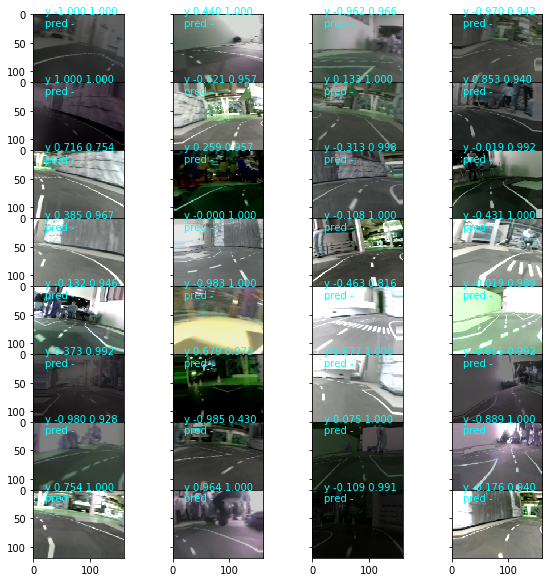

In [83]:
train_generator=create_generator(
    datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=[0.8, 1.2],
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.2, 1.5),
        shear_range=5.,
        channel_shift_range=50,
        vertical_flip=False, # we don't need it
        horizontal_flip=False, # We do it manually because we have to flip steering
    ),
    df=df_train
)
dbg_imgs, dbg_y = train_generator.next()
visualize(dbg_imgs, dbg_y, subplots_kwargs={'figsize': (10, 10)})

In [84]:
val_generator=create_generator(
    datagen=ImageDataGenerator(
        rescale=1./255,
        vertical_flip=False, # we don't need it
        horizontal_flip=False, # We do it manually because we have to flip steering
    ),
    df=df_val
)

Found 22820 validated image filenames.


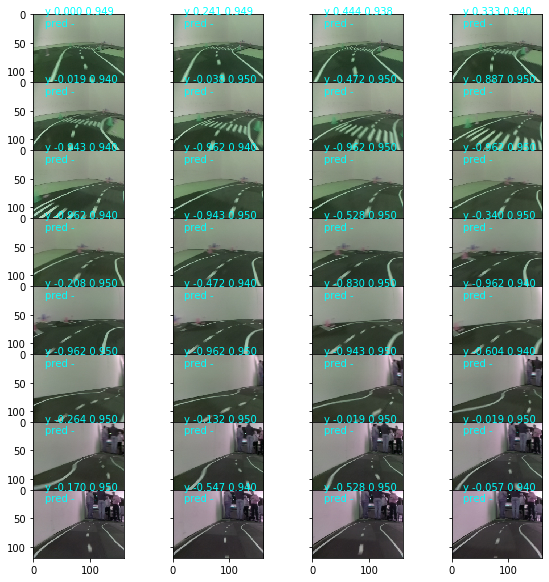

In [85]:
dbg_imgs, dbg_y = val_generator[50]
visualize(dbg_imgs, dbg_y, subplots_kwargs={'figsize': (10, 10)})

In [86]:
# np.set_printoptions(precision=3)

In [87]:
from keras_preprocessing.image.utils import load_img

In [88]:
dbg_y

[array([ 0.        ,  0.24074074,  0.44444444,  0.33333333, -0.01886792,
        -0.03773585, -0.47169811, -0.88679245, -0.94339623, -0.96226415,
        -0.96226415, -0.96226415, -0.96226415, -0.94339623, -0.52830189,
        -0.33962264, -0.20754717, -0.47169811, -0.83018868, -0.96226415,
        -0.96226415, -0.96226415, -0.94339623, -0.60377358, -0.26415094,
        -0.13207547, -0.01886792, -0.01886792, -0.16981132, -0.54716981,
        -0.52830189, -0.05660377]),
 array([0.94949495, 0.94949495, 0.9375    , 0.94      , 0.94      ,
        0.95      , 0.95      , 0.95      , 0.94      , 0.94      ,
        0.95      , 0.95      , 0.94      , 0.95      , 0.95      ,
        0.95      , 0.95      , 0.94      , 0.95      , 0.94      ,
        0.95      , 0.95      , 0.95      , 0.94      , 0.95      ,
        0.95      , 0.95      , 0.95      , 0.95      , 0.94      ,
        0.95      , 0.94      ])]

In [89]:
# def default_linear():
#     img_in = Input(shape=(120, 160, 3), name='img_in')
#     x = img_in

#     # Convolution2D class name is an alias for Conv2D
#     x = Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
#     x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
#     x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation='relu')(x)
#     x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(2, 2), activation='relu')(x)
#     x = Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(x)

#     x = Flatten(name='flattened')(x)
#     x = Dense(units=100, activation='relu')(x)
#     x = Dropout(rate=.1)(x)
#     x = Dense(units=50, activation='relu')(x)
#     x = Dropout(rate=.1)(x)
    
#     angle_out = Dense(units=1, activation='linear', name='angle_out')(x)

#     # continous output of throttle
#     throttle_out = Dense(units=1, activation='linear', name='throttle_out')(x)

#     model = Model(inputs=[img_in], outputs=[
#         angle_out, 
#         throttle_out
#     ])

#     model.compile(optimizer='adam',
#                   loss={
#                       'angle_out': 'mean_squared_error',
#                       'throttle_out': 'mean_squared_error'
#                   },
#                   loss_weights={
#                       'angle_out': 0.97, 
#                       'throttle_out': .03
#                   }
#                  )

#     return model

In [90]:
import keras
from keras_applications.resnet_common import stack1, ResNet

In [99]:
from keras_applications.resnet_common import stack1, ResNet50
# from tenso.keras.applications import ResNet50
import keras
def model_1():
    input_shape = (120, 160, 3)
    img_in = keras.layers.Input(shape=input_shape, name='img_in')
    x = img_in

    def stack_fn(x):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 32, 4, name='conv3_')
#         x = stack1(x, 256, 6, name='conv4')
#         x = stack1(x, 512, 3, name='conv5')
        return x

    resnet = ResNet(stack_fn, preact=False, use_bias=True, model_name='resnet50',
                  include_top=False, weights=None,
                  input_tensor=None, input_shape=(120, 160, 3),
                  pooling=None,
                   backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils
                   )  
   
    x = resnet(x)
    print(resnet.summary())
    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = keras.layers.Dense(128, activation='relu', name='head1')(x)

    angle_out = keras.layers.Dense(units=1, activation='linear', name='angle_out')(x)
    throttle_out = keras.layers.Dense(units=1, activation='linear', name='throttle_out')(x)

    model = keras.Model(inputs=[img_in], outputs=[
        angle_out, 
        throttle_out
    ])
    

    model.compile(optimizer='adam',
                  loss={
                      'angle_out': 'mean_squared_error',
                      'throttle_out': 'mean_squared_error'
                  },
                  loss_weights={
                      'angle_out': 0.97, 
                      'throttle_out': .03
                  }
                 )

    return model

In [100]:
model = model_1()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 126, 166, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 60, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 60, 80, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [101]:
def get_w_path(model_name):
    return "/home/s/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

weights_path = get_w_path('resnet50')
model.layers[1].load_weights(weights_path, by_name=True)

In [102]:
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
resnet50 (Model)                (None, 15, 20, 128)  340736      img_in[0][0]                     
__________________________________________________________________________________________________
avg_pool (GlobalAveragePooling2 (None, 128)          0           resnet50[1][0]                   
__________________________________________________________________________________________________
head1 (Dense)                   (None, 128)          16512       avg_pool[0][0]                   
____________________________________________________________________________________________

In [103]:
use_early_stop = True
epochs = 12
saved_model_path = Path("./models/linear_20191203_resnet_first_try.model")
verbose = True
min_delta=.0005
patience=5

In [104]:
len(train_generator), train_generator.n, train_generator.batch_size, 40*32

(2904, 92916, 32, 1280)

In [105]:
saved_model_path.parent.mkdir(exist_ok=True, parents=True)

In [106]:
save_best = ModelCheckpoint(str(saved_model_path),
                            monitor='val_loss',
                            verbose=verbose,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=verbose,
                           mode='auto')

log_dir = Path("logs") / f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}_{saved_model_path.stem}'
log_dir.mkdir(parents=True)

tb = TensorBoard(log_dir=str(log_dir))

callbacks_list = [save_best, tb]

if use_early_stop:
    callbacks_list.append(early_stop)

hist = model.fit_generator(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=val_generator,
    callbacks=callbacks_list)

Epoch 1/12
2904/2904 [==============================] - 5679s 2s/step - loss: 0.1182 - angle_out_loss: 0.1215 - throttle_out_loss: 0.0138 - val_loss: 0.1109 - val_angle_out_loss: 0.1139 - val_throttle_out_loss: 0.0162

Epoch 00001: val_loss improved from inf to 0.11093, saving model to models/linear_20191203_resnet_first_try.model
Epoch 2/12
2904/2904 [==============================] - 5551s 2s/step - loss: 0.0922 - angle_out_loss: 0.0948 - throttle_out_loss: 0.0101 - val_loss: 0.0915 - val_angle_out_loss: 0.0941 - val_throttle_out_loss: 0.0075

Epoch 00002: val_loss improved from 0.11093 to 0.09151, saving model to models/linear_20191203_resnet_first_try.model
Epoch 3/12
2904/2904 [==============================] - 5560s 2s/step - loss: 0.0857 - angle_out_loss: 0.0880 - throttle_out_loss: 0.0101 - val_loss: 0.1186 - val_angle_out_loss: 0.1220 - val_throttle_out_loss: 0.0085

Epoch 00003: val_loss did not improve from 0.09151
Epoch 4/12
2904/2904 [==============================] - 5550

KeyboardInterrupt: 

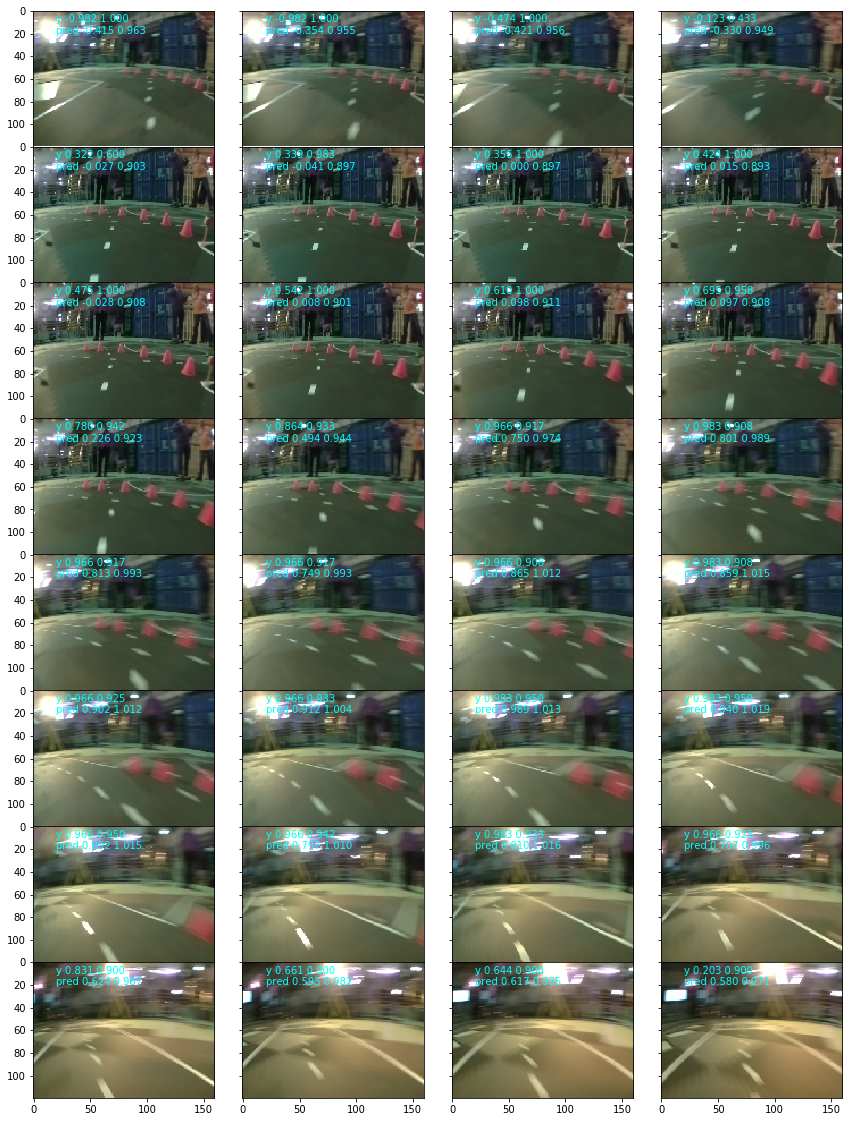

In [107]:
vis_imgs, vis_y = val_generator.next()
vis_pred = model.predict(vis_imgs)
visualize(vis_imgs, vis_y, vis_pred)

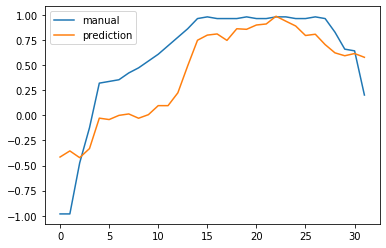

In [108]:
# steering
plt.plot(vis_y[0], label="manual")
plt.plot(vis_pred[0], label="prediction")
plt.legend()

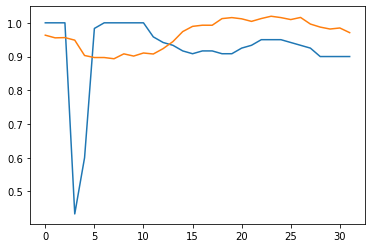

In [109]:
# Throttle
plt.plot(vis_y[1])
plt.plot(vis_pred[1])